In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/indoor-xy-floor/5da958dd46f8266d0737457b_2.csv
/kaggle/input/indoor-xy-floor/5d2709c303f801723c3299ee_1.csv
/kaggle/input/indoor-xy-floor/5d2709c303f801723c3299ee_-1.csv
/kaggle/input/indoor-xy-floor/5da958dd46f8266d0737457b_0.csv
/kaggle/input/indoor-xy-floor/5da138274db8ce0c98bbd3d2_2.csv
/kaggle/input/indoor-xy-floor/5d2709d403f801723c32bd39_0.csv
/kaggle/input/indoor-xy-floor/5d27096c03f801723c31e5e0_-1.csv
/kaggle/input/indoor-xy-floor/5c3c44b80379370013e0fd2b_2.csv
/kaggle/input/indoor-xy-floor/5da1382d4db8ce0c98bbe92e_1.csv
/kaggle/input/indoor-xy-floor/5c3c44b80379370013e0fd2b_1.csv
/kaggle/input/indoor-xy-floor/5da1389e4db8ce0c98bd0547_-2.csv
/kaggle/input/indoor-xy-floor/5dbc1d84c1eb61796cf7c010_4.csv
/kaggle/input/indoor-xy-floor/5da138754db8ce0c98bca82f_3.csv
/kaggle/input/indoor-xy-floor/5da138b74db8ce0c98bd4774_2.csv
/kaggle/input/indoor-xy-floor/5d2709c303f801723c3299ee_8.csv
/kaggle/input/indoor-xy-floor/5c3c44b80379370013e0fd2b_4.csv
/kaggle/input/indoor-

Thank you for reading, I would like to share the procedure I used to obtain my current best single-model results. Basically it consists of the following steps:
1. Fix data quality issues and reformat the training data through C++ custom code @ https://www.kaggle.com/oxzplvifi/indoor-cpp The procedure is shown @ https://www.kaggle.com/oxzplvifi/indoor-preprocessing-and-eda And the result is located @ https://www.kaggle.com/oxzplvifi/indoor-xy-floor
2. Use the hosts' GitHub scripts to generate a grid map of (floor,X,Y,rssi,magnetism) values from the "step detection" and "orientation detection" for training the models. The hosts' scripts are available @ https://github.com/location-competition/indoor-location-competition-20 Copyright (c) 2017-2020 XYZ10, Inc. https://dangwu.com/
3. Predict the floor for each path through KMeans and GBM. The procedure is shown @ https://www.kaggle.com/oxzplvifi/indoor-kmeans-gbm-floor-prediction
4. Predict the XY coordinates using the GBM model shared by BIZEN (hiro5299834) in his very nice work @ https://www.kaggle.com/hiro5299834/wifi-features-with-lightgbm-kfold , but using the (floor,X,Y,rssi,magnetism) grid map as input instead of the raw rssi data, and stratifying by floor.
5. The postprocessing procedure is explained near the end of this notebook.

In [2]:
# Prepare paths:
import glob
from pathlib import Path
inpath = '../input/indoor-location-navigation/'
metapath = inpath + 'metadata/'
trainpath = inpath + 'train/'
testpath = inpath + 'test/'

# Extract testing files, buildings and sites:
os.system(f'grep SiteID {testpath}/* > test_buildings.txt' )
test_buildings = pd.read_csv('test_buildings.txt',sep='\t',header=None,names=['file','building','site'])
test_buildings['file'] = test_buildings['file'].apply(lambda x: x[:-2])
test_buildings['building'] = test_buildings['building'].apply(lambda x: x[7:])

# How many buildings in the testing set?
buildings = np.unique(test_buildings['building'])
print('There are',len(buildings),'buildings in the testing set.')

test_buildings.head()

There are 24 buildings in the testing set.


,file,building,site
0,../input/indoor-location-navigation/test//00ff...,5da1389e4db8ce0c98bd0547,SiteName:和达城商场
1,../input/indoor-location-navigation/test//01c4...,5da138b74db8ce0c98bd4774,SiteName:万象城
2,../input/indoor-location-navigation/test//030b...,5da138764db8ce0c98bcaa46,SiteName:银泰百货
3,../input/indoor-location-navigation/test//0389...,5dbc1d84c1eb61796cf7c010,SiteName:杭州大悦城
4,../input/indoor-location-navigation/test//0402...,5da1383b4db8ce0c98bc11ab,SiteName:永旺梦乐城


In [3]:
# Compile C++ pre-processing code:
er=os.system("g++ /kaggle/input/indoor-cpp/1_preprocess.cpp -std=c++11 -o preprocess")
if(er): print("Error")

# Reformat the testing set:
os.system('mkdir test')
for i,(path_filename,building) in enumerate(zip(test_buildings['file'],test_buildings['building'])):
    er=os.system(f'./preprocess {path_filename} test {building} {0}') #since we do not know the floor, I put 0.
    if(er): print("Error:",path_filename)

In [4]:
# Acceleration, magnetic and orientation testing data:
os.system('mkdir indoor_testing_accel')
os.system("g++ /kaggle/input/indoor-cpp/2_preprocess_accel.cpp -std=c++11 -o preprocess_accel")
for building in buildings:
    os.system(f'./preprocess_accel {building}')

5a0546857ecc773753327266
5c3c44b80379370013e0fd2b
5d27075f03f801723c2e360f
5d27096c03f801723c31e5e0
5d27097f03f801723c320d97
5d27099f03f801723c32511d
5d2709a003f801723c3251bf
5d2709b303f801723c327472
5d2709bb03f801723c32852c
5d2709c303f801723c3299ee
5d2709d403f801723c32bd39
5d2709e003f801723c32d896
5da138274db8ce0c98bbd3d2
5da1382d4db8ce0c98bbe92e
5da138314db8ce0c98bbf3a0
5da138364db8ce0c98bc00f1
5da1383b4db8ce0c98bc11ab
5da138754db8ce0c98bca82f
5da138764db8ce0c98bcaa46
5da1389e4db8ce0c98bd0547
5da138b74db8ce0c98bd4774
5da958dd46f8266d0737457b
5dbc1d84c1eb61796cf7c010
5dc8cea7659e181adb076a3f


In [5]:
# Wifi testing data:
os.system('mkdir test_wifi')
os.system("g++ /kaggle/input/indoor-cpp/2_preprocess_wifi.cpp -std=c++11 -o preprocess_wifi")
for building in buildings:
    os.system(f'./preprocess_wifi {building}')

5a0546857ecc773753327266
5c3c44b80379370013e0fd2b
5d27075f03f801723c2e360f
5d27096c03f801723c31e5e0
5d27097f03f801723c320d97
5d27099f03f801723c32511d
5d2709a003f801723c3251bf
5d2709b303f801723c327472
5d2709bb03f801723c32852c
5d2709c303f801723c3299ee
5d2709d403f801723c32bd39
5d2709e003f801723c32d896
5da138274db8ce0c98bbd3d2
5da1382d4db8ce0c98bbe92e
5da138314db8ce0c98bbf3a0
5da138364db8ce0c98bc00f1
5da1383b4db8ce0c98bc11ab
5da138754db8ce0c98bca82f
5da138764db8ce0c98bcaa46
5da1389e4db8ce0c98bd0547
5da138b74db8ce0c98bd4774
5da958dd46f8266d0737457b
5dbc1d84c1eb61796cf7c010
5dc8cea7659e181adb076a3f


Procedure to produce floor results through KMeans+GBM @ https://www.kaggle.com/oxzplvifi/indoor-kmeans-gbm-floor-prediction

In [6]:
floors = pd.read_csv('/kaggle/input/indoor-xy-floor/result_floor_feb22.csv',index_col=0)
floors.head()

,floor,proba
5a0546857ecc773753327266_046cfa46be49fc10834815c6,0,0.961466
5a0546857ecc773753327266_05d052dde78384b0c543d89c,0,0.976916
5a0546857ecc773753327266_0c06cc9f21d172618d74c6c8,-1,0.986144
5a0546857ecc773753327266_146035943a1482883ed98570,-1,0.982314
5a0546857ecc773753327266_1ef2771dfea25d508142ba06,0,0.969909


Compute running average on the magnetic field and interpolate into the wifi coordinates of the testing set:

In [7]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import uniform_filter1d

for building in buildings:
    print(building)
    
    # Testing set:
    tfw = pd.read_csv(f'test_wifi/{building}.txt')
    tfw['path_id'] = [building+'_'+x for x in tfw.path_id]
    tfw = tfw.merge(floors['floor'],left_on='path_id',right_index=True)
    tfw = tfw.pivot_table(index=['path_id','t1_wifi','floor'],columns='bssid_wifi',values='rssid_wifi')
    tfw.fillna(-99.0,inplace=True)
    tfw.insert(0,'count',tfw.apply(lambda x: np.sum(x!=-99.0),axis=1))
    tfw.insert(0,'magn',0)
    paths = np.unique([x[0] for x in tfw.index])
    
    # Read magnetic signature:
    tfm = pd.read_csv(f'indoor_testing_accel/{building}.txt',index_col=0)
    tfm.index = [building+'_'+x for x in tfm.index]
    tfm['magn'] = np.sqrt(tfm['x_magn']**2 + tfm['y_magn']**2 + tfm['z_magn']**2)
    tfm = tfm.sort_values(by=['xyz_time'])
    
    # Interpolate the magnetic signature for each wifi timestamp:
    for path in paths:
        tm = tfm.loc[path,'xyz_time']
        m = uniform_filter1d(tfm.loc[path,'magn'], size=3, mode='reflect')
        fm = interp1d(tm,m,kind='linear',fill_value=(m[0],m[-1]),bounds_error=False) #fill_value="extrapolate"
        tw = [x[0] for x in tfw.loc[path].index]
        tfw.loc[path,'magn'] = fm(tw)
    
    # Save output:
    tfw = tfw.reset_index()
    tfw.to_csv(f'{building}.csv')
#     break

5a0546857ecc773753327266
5c3c44b80379370013e0fd2b
5d27075f03f801723c2e360f
5d27096c03f801723c31e5e0
5d27097f03f801723c320d97
5d27099f03f801723c32511d
5d2709a003f801723c3251bf
5d2709b303f801723c327472
5d2709bb03f801723c32852c
5d2709c303f801723c3299ee
5d2709d403f801723c32bd39
5d2709e003f801723c32d896
5da138274db8ce0c98bbd3d2
5da1382d4db8ce0c98bbe92e
5da138314db8ce0c98bbf3a0
5da138364db8ce0c98bc00f1
5da1383b4db8ce0c98bc11ab
5da138754db8ce0c98bca82f
5da138764db8ce0c98bcaa46
5da1389e4db8ce0c98bd0547
5da138b74db8ce0c98bd4774
5da958dd46f8266d0737457b
5dbc1d84c1eb61796cf7c010
5dc8cea7659e181adb076a3f


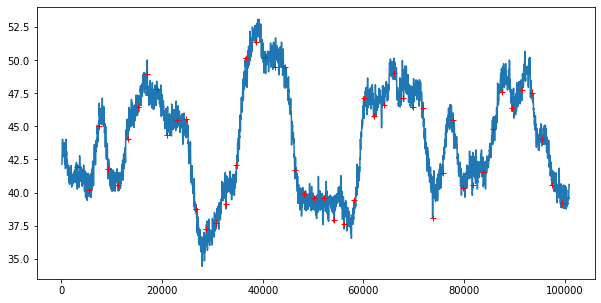

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(tfm.loc[path,'xyz_time'],m)
plt.plot(tw,fm(tw),'+r')
plt.show()

GBM parameters from BIZEN (hiro5299834) in his very nice work @ https://www.kaggle.com/hiro5299834/wifi-features-with-lightgbm-kfold

In [9]:
lgb_params = {
    'objective': 'root_mean_squared_error',
    'boosting_type': 'gbdt', #default=gbdt
    'n_estimators': 50000, #default=100*num_class
    'learning_rate': 0.1, #default=0.1
    'num_leaves': 90, #default=31
    'colsample_bytree': 0.4, #default=1.0 (% of cols selected)
    'subsample': 0.6, #default=1.0 (% of rows selected)
    'subsample_freq': 2, #default=0 (perform bagging every kth iteration)
    'bagging_seed': 42, #default=3
    'reg_alpha': 10, #default=0.0 (L1 regularization)
    'reg_lambda': 2, #default=0.0 (L2 regularization)
    'random_state': 42, #default=None
    'n_jobs': -1, #default=0
#     'device':'gpu'
}

Procedure to generate training tables and EDA @ https://www.kaggle.com/oxzplvifi/indoor-preprocessing-and-eda

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

result = pd.DataFrame(columns=['path_id','t1_wifi','x','y'])

for building in buildings:

    # Training set:
    xyw = pd.DataFrame()
    for floor in np.arange(-3,10):
        file = f'/kaggle/input/indoor-xy-floor/{building}_{floor}.csv'
        if Path(file).is_file():
            xyi = pd.read_csv(file,index_col=0)
            bcols = [c for c in xyi.columns if len(c.split('_'))==3] #beacon cols
            wcols = [c for c in xyi.columns if c not in ['x','y','count','magn']+bcols] #wifi cols
            xyi = xyi.loc[~np.isnan(xyi['count']),['x','y','count','magn']+wcols]
            xyi.insert(0,'floor',floor)
            if(len(xyw)):
                xyw = xyw.merge(xyi,how='outer')
            else: xyw = xyi
    xyw.replace(np.nan,-99.0,inplace=True)
    wcols = list(xyw.columns[5:])

    # Testing set:
    tfw = pd.read_csv(f'{building}.csv',index_col=0)
    tfw.set_index(['path_id','t1_wifi'],inplace=True)
    tfw = tfw.reindex(columns=['floor','magn']+wcols,fill_value=-99.0)

    # Arrays:
    dfmat = np.array(xyw[['floor','magn']+wcols])
    mtest = np.array(tfw)
    labs = np.array(xyw[['x','y']])
    yvalid = pd.DataFrame(np.zeros([len(labs),2]),index=xyw.index,columns=['x','y'])
    ytest = pd.DataFrame(np.zeros([len(tfw),2]),index=tfw.index,columns=['x','y'])

    # K-fold CV of coordinates:
    seeds, folds = 1, 10
    skf = StratifiedKFold(n_splits=folds,random_state=0,shuffle=True)
    for fold, (idt,idv) in enumerate(skf.split(dfmat,xyw['floor'])):
        print('\r',f'{fold}',end='\t')
        mtrain, mvalid = dfmat[idt], dfmat[idv] #特征是floor mag 和所有wifi
        ltrain, lvalid = labs[idt], labs[idv]#标签是x,y
        #分别拟合 x  和。 y
        # X prediction:
        modelx = lgb.LGBMRegressor(**lgb_params)
        modelx.fit(mtrain,ltrain[:,0],eval_set=[(mvalid,lvalid[:,0])],eval_metric='rmse',early_stopping_rounds=10,verbose=False)
        yvalid.loc[xyw.index[idv],'x'] = modelx.predict(mvalid)
#         modelx.booster_.save_model(f'lgb/{building}_{fold}_x.txt',num_iteration=modelx.best_iteration_)
#         modelx = lgb.Booster(model_file=f'lgb/{building}_{fold}_x.txt')
        ytest['x'] += modelx.predict(mtest) / folds
        # Y prediction:
        modely = lgb.LGBMRegressor(**lgb_params)
        modely.fit(mtrain,ltrain[:,1],eval_set=[(mvalid,lvalid[:,1])],eval_metric='rmse',early_stopping_rounds=10,verbose=False)
#         modely.booster_.save_model( f'lgb/{building}_{fold}_y.txt',num_iteration=modely.best_iteration_)
#         modely = lgb.Booster(model_file=f'lgb/{building}_{fold}_y.txt')
        yvalid.loc[xyw.index[idv],'y'] = modely.predict(mvalid)
        ytest['y'] += modely.predict(mtest) / folds

    # Performance:
    yvalid['xtruth'] = xyw['x']
    yvalid['ytruth'] = xyw['y']
    xrmse = np.sqrt((yvalid['x']-yvalid['xtruth'])**2)
    yrmse = np.sqrt((yvalid['y']-yvalid['ytruth'])**2)
    print(building, f'xrmse = {np.mean(xrmse)}, yrmse = {np.mean(yrmse)}')

    # Prediction:
    result = pd.concat([result,ytest.reset_index()])
#     break

result.set_index('path_id',inplace=True)

 9	5a0546857ecc773753327266 xrmse = 1.82449793497846, yrmse = 1.369805772619651
 9	5c3c44b80379370013e0fd2b xrmse = 2.0403003602545633, yrmse = 1.523308453747644
 9	5d27075f03f801723c2e360f xrmse = 2.0309404492473164, yrmse = 1.5815331395520864
 9	5d27096c03f801723c31e5e0 xrmse = 1.3353284858376195, yrmse = 1.340746563418705
 9	5d27097f03f801723c320d97 xrmse = 2.04041479570027, yrmse = 2.670134380894907
 9	5d27099f03f801723c32511d xrmse = 1.043434975359525, yrmse = 1.6290263275635406
 9	5d2709a003f801723c3251bf xrmse = 1.5508846037271633, yrmse = 1.3269377854300837
 9	5d2709b303f801723c327472 xrmse = 1.8427973576649186, yrmse = 1.6028528139415867
 9	5d2709bb03f801723c32852c xrmse = 1.7687189186267633, yrmse = 1.8480131935406667
 7	

The predicted XY values correspond to the WIFI timestamps, not to the submission timepoints. Therefore, we must interpolate them. Prior to interpolation, we employ the hosts' GitHub scripts containing the "step detection" and "orientation detection" procedures in order to improve the prediction @ https://github.com/location-competition/indoor-location-competition-20 Copyright (c) 2017-2020 XYZ10, Inc. https://dangwu.com/

In [ ]:
import numpy as np
import scipy.signal as signal


def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions


def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, posi_datas)

    return step_positions

def extract_magnetic_strength(mwi_datas):
    magnetic_strength = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')
        magnetic_data = mwi_datas[position_key]['magnetic']
        magnetic_s = np.mean(np.sqrt(np.sum(magnetic_data[:, 1:4] ** 2, axis=1)))
        magnetic_strength[position_key] = magnetic_s
    return magnetic_strength

def extract_wifi_rssi(mwi_datas):
    wifi_rssi = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')
        wifi_data = mwi_datas[position_key]['wifi']
        for wifi_d in wifi_data:
            bssid = wifi_d[2]
            rssi = int(wifi_d[3])
            if bssid in wifi_rssi:
                position_rssi = wifi_rssi[bssid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])

            wifi_rssi[bssid] = position_rssi
    return wifi_rssi

def extract_ibeacon_rssi(mwi_datas):
    ibeacon_rssi = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')
        ibeacon_data = mwi_datas[position_key]['ibeacon']
        for ibeacon_d in ibeacon_data:
            ummid = ibeacon_d[1]
            rssi = int(ibeacon_d[2])
            if ummid in ibeacon_rssi:
                position_rssi = ibeacon_rssi[ummid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])
            ibeacon_rssi[ummid] = position_rssi
    return ibeacon_rssi

def extract_wifi_count(mwi_datas):
    wifi_counts = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')
        wifi_data = mwi_datas[position_key]['wifi']
        count = np.unique(wifi_data[:, 2]).shape[0]
        wifi_counts[position_key] = count
    return wifi_counts

In [ ]:
# Load submission file to see which timepoints are required:
sample_submission = pd.read_csv(inpath+'sample_submission.csv')
sample_submission['building'] = [x.split('_')[0] for x in sample_submission['site_path_timestamp']]
sample_submission['path_id'] = [x.split('_')[1] for x in sample_submission['site_path_timestamp']]
sample_submission['timestamp'] = [x.split('_')[2] for x in sample_submission['site_path_timestamp']]
samples = pd.DataFrame(sample_submission.groupby(['building','path_id'])['timestamp'].apply(lambda x: list(x)))
buildings = np.unique([x[0] for x in samples.index])
samples.head()

The following is my postprocessing procedure:
1. First we remove the outliers by comparing each value to its running average (i.e. we get the distribution of differences between the original values and the running average and use 3 standard deviations as the outlier threshold).
2. Then we run the hosts' scripts to detect steps and orientation.
3. Then we do another running average. But we do not keep all values because if we do that, then the time interval between consecutive timepoints will be too short to make any use of the hosts' script to take into account the steps and orientation. So instead we keep a third of the data points, so that each point is an average of three original data prediction timepoints.
4. Then we run the hosts' scripts to correct the position using the step and orientation.
5. Finally, we interpolate to the desired timepoints.

In [ ]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import uniform_filter1d

colacce = ['xyz_time','x_acce','y_acce','z_acce']
colahrs = ['xyz_time','x_ahrs','y_ahrs','z_ahrs']

for building in buildings:
    print(building)
    paths = samples.loc[building].index
    # Acceleration info:
    tfm = pd.read_csv(f'indoor_testing_accel/{building}.txt',index_col=0)
    for path_id in paths:
        # Original predicted values:
        xy = result.loc[building+'_'+path_id]
        tfmi = tfm.loc[path_id]
        acce_datas = np.array(tfmi[colacce],dtype=np.float)
        ahrs_datas = np.array(tfmi[colahrs],dtype=np.float)
        posi_datas = np.array(xy[['t1_wifi','x','y']],dtype=np.float)
        # 1.Outlier removal:
        xyout = uniform_filter1d(posi_datas,size=3,axis=0,mode='reflect')
        xydiff = np.abs(posi_datas-xyout)
        xystd = np.std(xydiff,axis=0)*3
        posi_datas = posi_datas[(xydiff[:,1]<xystd[1])&(xydiff[:,2]<xystd[2])]
        # 2.1 Step detection:
        step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
        stride_lengths = compute_stride_length(step_acce_max_mins)
        # 2.2 Orientation detection:
        headings = compute_headings(ahrs_datas)
        step_headings = compute_step_heading(step_timestamps, headings)
        rel_positions = compute_rel_positions(stride_lengths, step_headings)
        # 3. Running average:
        posi_datas = uniform_filter1d(posi_datas,size=3,axis=0,mode='reflect')[0::3,:]
        # The 1st prediction timepoint should be earlier than the 1st step timepoint.
        rel_positions = rel_positions[rel_positions[:,0]>posi_datas[0,0],:]
        # If two consecutive predictions are in-between two step datapoints,
        # the last one is removed, causing error (in the "split_ts_seq" function).
        posi_index = [np.searchsorted(rel_positions[:,0], x, side='right') for x in posi_datas[:,0]]
        u, i1, i2 = np.unique(posi_index, return_index=True, return_inverse=True)
        posi_datas = np.vstack([np.mean(posi_datas[i2==i],axis=0) for i in np.unique(i2)])
        # 4.Position correction:
        step_positions = correct_positions(rel_positions, posi_datas)
        # 5.Interpolate for timestamps in the testing set:
        t = step_positions[:,0]
        x = step_positions[:,1]
        y = step_positions[:,2]
        fx = interp1d(t, x, kind='linear', fill_value=(x[0],x[-1]), bounds_error=False) #fill_value="extrapolate"
        fy = interp1d(t, y, kind='linear', fill_value=(y[0],y[-1]), bounds_error=False)
        # 6.Output result:
        t0 = np.array(samples.loc[(building,path_id),'timestamp'],dtype=np.float64)
        sample_submission.loc[(sample_submission.building==building)&(sample_submission.path_id==path_id),'x'] = fx(t0)
        sample_submission.loc[(sample_submission.building==building)&(sample_submission.path_id==path_id),'y'] = fy(t0)
        sample_submission.loc[(sample_submission.building==building)&(sample_submission.path_id==path_id),'floor'] = floors.loc[building+'_'+path_id,'floor']
#         break
#     break

sample_submission[['site_path_timestamp','floor','x','y']].to_csv('submission.csv',index=False)
sample_submission.head()

Visualize the postprocessing procedure:

In [ ]:
# Original predicted values:
xy = result.loc[building+'_'+path_id]
posi_datas = np.array(xy[['t1_wifi','x','y']],dtype=np.float)

# Outlier removal (|Z-score|>3 of difference with running average):
xyout = uniform_filter1d(posi_datas,size=3,axis=0,mode='reflect')
xydiff = np.abs(posi_datas-xyout)
xystd = np.std(xydiff,axis=0)*3
posi_datas = posi_datas[(xydiff[:,1]<xystd[1])&(xydiff[:,2]<xystd[2])]

plt.figure(figsize=(20,10))
plt.plot(xy.t1_wifi,xy.x,'+-b')
plt.plot(posi_datas[:,0],posi_datas[:,1],'+-r')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(xy.t1_wifi,xy.y,'+-b')
plt.plot(posi_datas[:,0],posi_datas[:,2],'+-r')
plt.show()

In [ ]:
# Step detection:
tfmi = tfm.loc[path_id]
step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
stride_lengths = compute_stride_length(step_acce_max_mins)
plt.figure(figsize=(20,10))

# Step detection is to detect at which timepoints the person walked:
plt.plot(tfmi['xyz_time'],tfmi['z_acce'],label='az')
plt.plot(step_acce_max_mins[:,0],step_acce_max_mins[:,1],'*-',label='max')
plt.plot(step_acce_max_mins[:,0],step_acce_max_mins[:,2],'*-',label='min')
plt.plot(step_acce_max_mins[:,0],step_acce_max_mins[:,3],'*-',label='variance')
plt.legend()
plt.title('Step detection')
plt.show()

# Stride length is related to the distance traveled in each step:
plt.figure(figsize=(20,10))
plt.plot(stride_lengths[:,0],stride_lengths[:,1],'*-')
plt.title('Stride length')
plt.show()

In [ ]:
# Orientation detection:
headings = compute_headings(ahrs_datas)
step_headings = compute_step_heading(step_timestamps, headings)
rel_positions = compute_rel_positions(stride_lengths, step_headings)

plt.figure(figsize=(20,10))
plt.plot(tfmi['xyz_time'],tfmi['x_ahrs'],label='x_ahrs')
plt.plot(tfmi['xyz_time'],tfmi['y_ahrs'],label='y_ahrs')
plt.plot(tfmi['xyz_time'],tfmi['z_ahrs'],label='z_ahrs')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(headings[:,0],headings[:,1],label='around_z')
plt.plot(step_headings[:,0],step_headings[:,1],'*-',label='around_z')
plt.legend()
plt.show()

In [ ]:
# Position correction:
posi_avg = uniform_filter1d(posi_datas,size=3,axis=0,mode='reflect')[0::3,:]
#The first prediction timepoint should be earlier than the first step timepoint.
rel_positions = rel_positions[rel_positions[:,0]>posi_avg[0,0],:]
#If two consecutive predictions are in-between two step datapoints,
#the last one is removed, causing error (in the "split_ts_seq" function).
posi_index = [np.searchsorted(rel_positions[:,0], x, side='right') for x in posi_avg[:,0]]
u, i1, i2 = np.unique(posi_index, return_index=True, return_inverse=True)
posi_avg = np.vstack([np.mean(posi_avg[i2==i],axis=0) for i in np.unique(i2)])
step_positions = correct_positions(rel_positions, posi_avg)

plt.figure(figsize=(20,10))
plt.plot(rel_positions[:,0],rel_positions[:,1],'*-',label='stride*-sin')
plt.plot(rel_positions[:,0],rel_positions[:,2],'*-',label='stride*cos')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(posi_datas[:,0],posi_datas[:,1],'*-',label='x waypoint')
plt.plot(posi_avg[:,0],posi_avg[:,1],'*-',label='x waypoint avg')
plt.plot(step_positions[:,0],step_positions[:,1],'-',label='x step')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(posi_datas[:,0],posi_datas[:,2],'*-',label='y waypoint')
plt.plot(posi_avg[:,0],posi_avg[:,2],'*-',label='y waypoint avg')
plt.plot(step_positions[:,0],step_positions[:,2],'-',label='y step')
plt.legend()
plt.show()

Thank you for reading! Let me know if you have any questions, and I look forward to any suggestions!